In [1]:
from __future__ import annotations

from ast import literal_eval
import sys; sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [3]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw_pos{}.csv"
RAW_DATA_MAXLEN = ['none',
                  # '300', '200'
                ]

In [4]:
models_df = pd.DataFrame({
    'model': [
        'LSVM', 
        'LogReg'
    ],
    'base': [
        SGDClassifier(loss='hinge'),
        SGDClassifier(loss='log_loss'), # 'log' is deprecated in 1.1
    ],
    'common_params': [
        {
            'clf__alpha': np.logspace(-4, 2, 7),
        },
        {
            'clf__alpha': np.logspace(-4, 2, 7),
        },
    ],
    'params': [
        {
            'cxf__words__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'cxf__chars__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'cxf__postg__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'cxf__words__min_df': [3, 5, 10],
        },
        {
            'cxf__words__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'cxf__chars__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'cxf__postg__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'cxf__words__min_df': [3, 5, 10],
        },
    ],
})

In [5]:
all_results = pd.DataFrame()

(7895, 2) (2029, 2) (7895,) (2029,)

======================================LSVM====================================== ======================================none======================================
---------------------------------With $min-df$----------------------------------
Fitting 10 folds for each of 567 candidates, totalling 5670 fits
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1041
           1       0.71      0.82      0.76       988

    accuracy                           0.75      2029
   macro avg       0.75      0.75      0.75      2029
weighted avg       0.75      0.75      0.75      2029


Saved confusion matrix: ../results/figures/sgd_0.746_min_df_20221229_1526.svg
LSVM done

=====================================LogReg===================================== ======================================none======================================
---------------------------------With $min-df$------------------------------

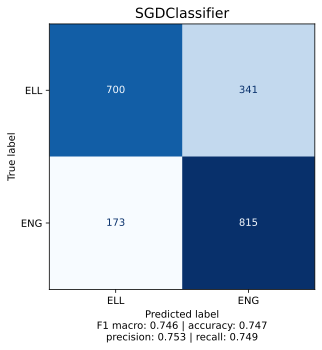

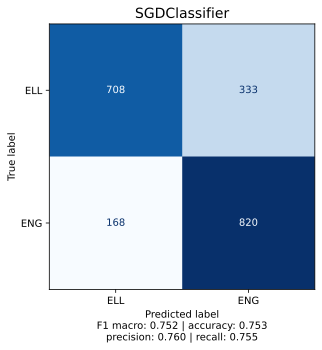

In [6]:
for maxlen in RAW_DATA_MAXLEN:
    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''),
                                           encoding='utf-8')

    df, labels = encode_labels(df, 'label')

    X = df[['text', 'pos_tags']]
    y = df['label']

    gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, end="\n\n")


    # run cross-validation, each time using only one of the three features
    word_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
    char_vect = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
    post_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

    for i, row in models_df.iterrows():
        model = row['model']
        base = row['base']
        common_params = row['common_params']
        params = row['params']

        cxf = ColumnTransformer(
            [
                ('words', word_vect, 'text'),
                ('chars', char_vect, 'text'),
                ('postg', post_vect, 'pos_tags'),
            ],
            remainder='drop',
        )

        pipe = Pipeline([
            ('cxf', cxf),
            ('clf', base),
        ])


        print(f"{model:=^80} {maxlen:=^80}")
        print("With $min-df$".center(80, "-"))
        gs_grid = GridSearchCV(pipe, {**common_params, **params}, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        gs_grid.fit(X_train, y_train)
        y_pred = gs_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='min_df')
        gs_results = pd.DataFrame(gs_grid.cv_results_)
        gs_results['model'] = model
        gs_results['maxlen'] = maxlen
        all_results = pd.concat([all_results, gs_results])

        print(f"{model} done", end="\n\n")

In [7]:
# sort values in params column
all_results['params'] = all_results['params'].apply(lambda x: str(x))
all_results = all_results.sort_values(by='params')
all_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_cxf__chars__ngram_range,param_cxf__postg__ngram_range,param_cxf__words__min_df,param_cxf__words__ngram_range,params,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model,maxlen
6,2.310503,0.079740,0.251563,0.017995,0.0001,"(1, 1)","(1, 1)",10,"(1, 1)","{'clf__alpha': 0.0001, 'cxf__chars__ngram_rang...",...,0.705694,0.708413,0.808743,0.850390,0.814013,0.769193,0.049565,52,LogReg,none
6,2.758309,0.212454,0.297507,0.052065,0.0001,"(1, 1)","(1, 1)",10,"(1, 1)","{'clf__alpha': 0.0001, 'cxf__chars__ngram_rang...",...,0.699600,0.700155,0.831432,0.837240,0.814770,0.761200,0.053708,65,LSVM,none
7,3.473074,0.122221,0.324833,0.024894,0.0001,"(1, 1)","(1, 1)",10,"(1, 2)","{'clf__alpha': 0.0001, 'cxf__chars__ngram_rang...",...,0.670553,0.722111,0.822080,0.876926,0.771873,0.762622,0.056421,79,LogReg,none
7,3.929098,0.358701,0.348582,0.036850,0.0001,"(1, 1)","(1, 1)",10,"(1, 2)","{'clf__alpha': 0.0001, 'cxf__chars__ngram_rang...",...,0.699822,0.695406,0.805633,0.860583,0.810842,0.756947,0.053221,108,LSVM,none
8,4.809101,0.092436,0.406438,0.026065,0.0001,"(1, 1)","(1, 1)",10,"(1, 3)","{'clf__alpha': 0.0001, 'cxf__chars__ngram_rang...",...,0.715121,0.718555,0.815293,0.857355,0.817840,0.769045,0.050545,55,LogReg,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,9.750037,0.438438,1.027719,0.145403,100.0,"(1, 3)","(1, 3)",5,"(1, 1)","{'clf__alpha': 100.0, 'cxf__chars__ngram_range...",...,0.331922,0.331922,0.331922,0.331922,0.334739,0.332795,0.001404,536,LogReg,none
562,10.062060,0.235389,1.029503,0.061392,100.0,"(1, 3)","(1, 3)",5,"(1, 2)","{'clf__alpha': 100.0, 'cxf__chars__ngram_range...",...,0.334739,0.331922,0.331922,0.331922,0.334739,0.333414,0.001500,472,LSVM,none
562,10.854519,0.491250,1.105654,0.073564,100.0,"(1, 3)","(1, 3)",5,"(1, 2)","{'clf__alpha': 100.0, 'cxf__chars__ngram_range...",...,0.331922,0.331922,0.334739,0.331922,0.331922,0.332457,0.001223,561,LogReg,none
563,12.173416,0.380070,1.136474,0.051589,100.0,"(1, 3)","(1, 3)",5,"(1, 3)","{'clf__alpha': 100.0, 'cxf__chars__ngram_range...",...,0.334739,0.331922,0.334739,0.334739,0.331922,0.333921,0.001381,423,LogReg,none


In [8]:
all_results = all_results.reset_index(drop=True)
all_results.to_csv('all_results_lsvm_logreg_ngrams_min_df.csv', index=False, encoding='utf-8')

In [29]:
import pandas as pd
from ast import literal_eval
from IPython.display import display as ipy_display


with pd.option_context('display.max_rows', None):
    all_res = all_results[['model', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
    all_res['alpha'] = all_res['params'].apply(lambda x: x['clf__alpha'])
    all_res['n_grams'] = all_res['params'].apply(lambda x: x['cxf__words__ngram_range']).astype(str)
    all_res = all_res.rename(columns={'mean_test_score': 'F1-score', 'std_test_score': 'std'})
    all_res = all_res.sort_values(by=['model', 'alpha'])
    all_res = all_res.groupby(['model', 'alpha', 'n_grams']).agg({'F1-score': 'mean', 'std': 'mean'})
    all_res = all_res.unstack('model')  # move model to columns and group by model
    all_res = all_res.swaplevel(axis=1).sort_index(axis=1)  # swap F1-score and std columns with model

    ipy_display(all_res)

# all_res.to_latex('all_results_lsvm_logreg_single_feats.tex', encoding='utf-8')

C:\Users\dimboump\AppData\Local\Temp\ipykernel_42700\2691218223.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
C:\Users\dimboump\AppData\Local\Temp\ipykernel_42700\2691218223.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['alpha'] = all_res['params'].apply(lambda x: x['clf__alpha'])
C:\Users\dimboump\AppData\Local\Temp\ipykernel_42700\2691218223.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

model                 LSVM              LogReg          
                  F1-score       std  F1-score       std
alpha    n_grams                                        
0.0001   (1, 1)   0.760988  0.049229  0.773200  0.050037
         (1, 2)   0.760880  0.048356  0.770616  0.051590
         (1, 3)   0.760311  0.047882  0.770686  0.051205
0.0010   (1, 1)   0.760631  0.057006  0.748399  0.055014
         (1, 2)   0.754121  0.058184  0.739497  0.055817
         (1, 3)   0.752460  0.058519  0.738790  0.053735
0.0100   (1, 1)   0.596720  0.091924  0.687649  0.071007
         (1, 2)   0.570767  0.089569  0.670667  0.073347
         (1, 3)   0.563238  0.090853  0.667174  0.073848
0.1000   (1, 1)   0.404211  0.044448  0.590405  0.087196
         (1, 2)   0.392900  0.034376  0.570793  0.085174
         (1, 3)   0.392070  0.034486  0.567095  0.085622
1.0000   (1, 1)   0.436055  0.100058  0.454483  0.100218
         (1, 2)   0.420624  0.088545  0.446352  0.101100
         (1, 3)   0.420893  0.089799  0.445756  0.100973
10.0000  (1, 1)   0.333506  0.001375  0.333968  0.003128
         (1, 2)   0.333277  0.001425  0.333268  0.001437
         (1, 3)   0.333506  0.001419  0.333193  0.001401
100.0000 (1, 1)   0.333244  0.001415  0.333341  0.001420
         (1, 2)   0.333312  0.001429  0.333268  0.001420
         (1, 3)   0.333327  0.001459  0.333360  0.001460

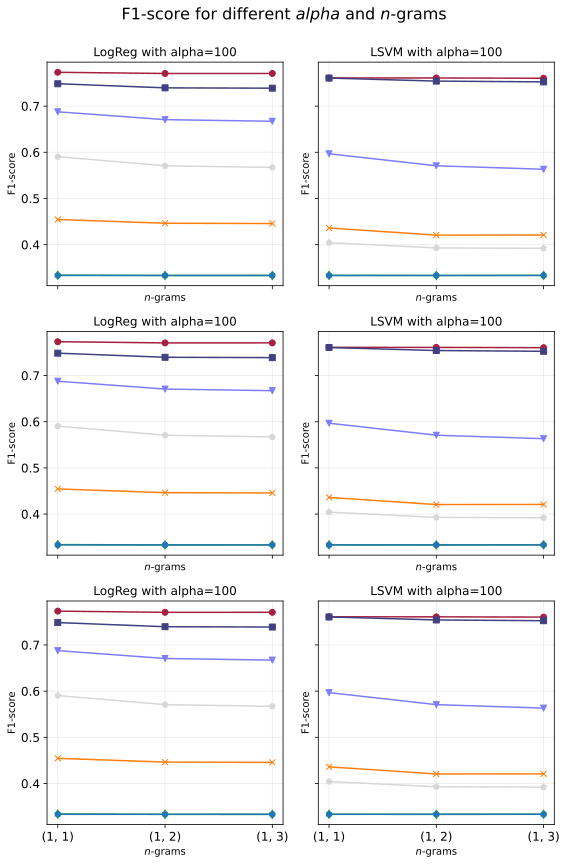

In [46]:
from matplotlib.pyplot import Line2D

markers = ['o', 's', 'v', 'p', 'x', 'd', 'h']
colors = ['#a52040', '#404080', '#7d7dfa', '#d7d7d7', '#ff7f0e', '#2ca02c', '#1f77b4']

fig, axes = plt.subplots(3, 2, figsize=(8, 12), sharey=True, sharex=True)

for i, model in enumerate(['LogReg', 'LSVM']):
    for j, n_gram in enumerate(['(1, 1)', '(1, 2)', '(1, 3)']):
        for k, alpha in enumerate([0.0001, 0.001, 0.01, 0.1, 1, 10, 100]):
            df = all_res.loc[alpha, model]
            mean = df['F1-score']
            std = df['std']
            n_grams = df.index
            axes[j, i].plot(n_grams, mean, label=n_gram, zorder=3, marker=markers[k], color=colors[k])
            axes[j, i].set_title(fr'{model} with {alpha=}')
            axes[j, i].set_xticks(n_grams)
            axes[j, i].set_xticklabels(n_grams)
            axes[j, i].tick_params(axis='x', labelsize=12)
            axes[j, i].tick_params(axis='y', labelsize=12)
            axes[j, i].set_xlabel('$n$-grams')
            axes[j, i].set_ylabel('F1-score')
            axes[j, i].grid(zorder=0, alpha=0.25)

fig.suptitle('F1-score for different $alpha$ and $n$-grams', fontsize=16, y=1)
fig.tight_layout()